In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # visualização gráfica
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.tree import plot_tree
import warnings
import shap
warnings.filterwarnings('ignore')

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def espec_sens(observado,predicts):
    
    # adicionar objeto com os valores dos predicts
    # values = predicts.values
    values = predicts
    
    # range dos cutoffs a serem analisados em steps de 0.01
    cutoffs = np.arange(0,1.01,0.01)
    
    # Listas que receberão os resultados de especificidade e sensitividade
    lista_sensitividade = []
    lista_especificidade = []
    
    for cutoff in cutoffs:
        
        predicao_binaria = []
        
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                predicao_binaria.append(1)
            else:
                predicao_binaria.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff
        sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
        especificidade = recall_score(observado, predicao_binaria, pos_label=0)
        
        # Adicionar valores nas listas
        lista_sensitividade.append(sensitividade)
        lista_especificidade.append(especificidade)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitividade':lista_sensitividade,'especificidade':lista_especificidade})
    return resultado

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_base_nativa = pd.read_excel('DadosClientesProjeto.xlsx')
df_base_nativa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6038 entries, 0 to 6037
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Segmento                      6038 non-null   object 
 1   UF                            6038 non-null   object 
 2   Municipio                     6038 non-null   object 
 3   DiasDesdePrimeiroFaturamento  6038 non-null   int64  
 4   DiasDesdeUltimoFaturamento    6038 non-null   int64  
 5   MediaMargemRelativa           6038 non-null   float64
 6   SomaValorFaturado             6038 non-null   float64
 7   ProdutosDiferentesComprados   6038 non-null   int64  
 8   TicketMedio                   6038 non-null   float64
 9   QuantidadePedidos             6038 non-null   int64  
 10  QuantidadeMesesComprando      6038 non-null   int64  
 11  TaxaConversaoOrcamentos       6038 non-null   float64
 12  ContratoAtivo                 6038 non-null   object 
 13  Mes

In [4]:
# replace de valores em brancos ou espaços para NaN
df_base_nativa.replace(r'^\s*$', np.nan, regex=True, inplace=True)
# confere valores NaN
df_base_nativa.isna().sum()

Segmento                         0
UF                               0
Municipio                        0
DiasDesdePrimeiroFaturamento     0
DiasDesdeUltimoFaturamento       0
MediaMargemRelativa              0
SomaValorFaturado                0
ProdutosDiferentesComprados      0
TicketMedio                      0
QuantidadePedidos                0
QuantidadeMesesComprando         0
TaxaConversaoOrcamentos          0
ContratoAtivo                    0
MesesConsecutivosComprando       0
MediaFrete                       0
FretePadrao                      0
DescCondPag                     17
Churn                            0
ClienteLoja                      0
dtype: int64

In [5]:
df_base = df_base_nativa.dropna()
df_base.drop(['DiasDesdePrimeiroFaturamento', 'DiasDesdeUltimoFaturamento'], axis=1, inplace=True)
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6021 entries, 0 to 6037
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Segmento                     6021 non-null   object 
 1   UF                           6021 non-null   object 
 2   Municipio                    6021 non-null   object 
 3   MediaMargemRelativa          6021 non-null   float64
 4   SomaValorFaturado            6021 non-null   float64
 5   ProdutosDiferentesComprados  6021 non-null   int64  
 6   TicketMedio                  6021 non-null   float64
 7   QuantidadePedidos            6021 non-null   int64  
 8   QuantidadeMesesComprando     6021 non-null   int64  
 9   TaxaConversaoOrcamentos      6021 non-null   float64
 10  ContratoAtivo                6021 non-null   object 
 11  MesesConsecutivosComprando   6021 non-null   int64  
 12  MediaFrete                   6021 non-null   float64
 13  FretePadrao            

In [6]:
df_base.duplicated().sum()

0

In [7]:
lista_colunas_qualitativas = ['Segmento', 'UF', 'Municipio', 'ContratoAtivo', 'FretePadrao', 'DescCondPag']

In [8]:
lista_colunas_quantitativas = ['MediaMargemRelativa','SomaValorFaturado', 'ProdutosDiferentesComprados', 'TicketMedio', 
                               'QuantidadePedidos', 'QuantidadeMesesComprando', 'TaxaConversaoOrcamentos', 
                               'MesesConsecutivosComprando', 'MediaFrete']

In [9]:
df_base.groupby('Churn').describe().T

Churn                           0       1
MediaMargemRelativa count 1966.00 4055.00
                    mean     0.23    0.25
                    std      0.68    0.43
                    min    -29.61  -24.56
                    25%      0.19    0.18
...                           ...     ...
ClienteLoja         min      0.00    3.00
                    25%   1300.25 1661.50
                    50%   2712.00 3165.00
                    75%   4383.75 4573.50
                    max   6038.00 5997.00

[80 rows x 2 columns]

In [10]:
df_base.describe().T

,count,mean,std,min,25%,50%,75%,max
MediaMargemRelativa,6021.00,0.24,0.52,-29.61,0.19,0.23,0.30,1.09
SomaValorFaturado,6021.00,92953.03,693858.77,-1872.94,1503.37,7248.72,35498.23,31063600.82
ProdutosDiferentesComprados,6021.00,24.52,43.15,1.00,3.00,9.00,27.00,860.00
TicketMedio,6021.00,1301.80,5996.93,-650.00,237.69,522.02,1148.39,308402.66
QuantidadePedidos,6021.00,24.53,228.34,1.00,1.00,3.00,10.00,13122.00
QuantidadeMesesComprando,6021.00,8.06,9.30,1.00,1.00,4.00,11.00,35.00
TaxaConversaoOrcamentos,6021.00,0.53,0.30,0.01,0.26,0.50,0.79,1.00
MesesConsecutivosComprando,6021.00,8.72,10.08,1.00,2.00,4.00,12.00,39.00
MediaFrete,6021.00,47.39,436.31,-17.56,2.33,16.70,46.56,33000.09
Churn,6021.00,0.67,0.47,0.00,0.00,1.00,1.00,1.00


In [11]:
print(df_base.describe().T.to_string())

                              count     mean       std      min     25%     50%      75%         max
MediaMargemRelativa         6021.00     0.24      0.52   -29.61    0.19    0.23     0.30        1.09
SomaValorFaturado           6021.00 92953.03 693858.77 -1872.94 1503.37 7248.72 35498.23 31063600.82
ProdutosDiferentesComprados 6021.00    24.52     43.15     1.00    3.00    9.00    27.00      860.00
TicketMedio                 6021.00  1301.80   5996.93  -650.00  237.69  522.02  1148.39   308402.66
QuantidadePedidos           6021.00    24.53    228.34     1.00    1.00    3.00    10.00    13122.00
QuantidadeMesesComprando    6021.00     8.06      9.30     1.00    1.00    4.00    11.00       35.00
TaxaConversaoOrcamentos     6021.00     0.53      0.30     0.01    0.26    0.50     0.79        1.00
MesesConsecutivosComprando  6021.00     8.72     10.08     1.00    2.00    4.00    12.00       39.00
MediaFrete                  6021.00    47.39    436.31   -17.56    2.33   16.70    46.56   

In [12]:
for coluna in lista_colunas_qualitativas:
    print(df_base[coluna].value_counts())
    print('-=' * 20)

Segmento
REVENDA                                       1471
MANUFATURA EM GERAL E SERVICOS SECUNDARIOS    1146
PRESTADOR DE SERVICO                           576
AGRONEGOCIO                                    491
TRANSPORTE & LOGISTICA                         348
ALIMENTOS & BEBIDAS                            288
SIDERURGIA & METALURGIA                        265
VAREJO & ATACADO                               223
CONSTRUCAO CIVIL                               211
QUIMICA                                        207
PETROLEO E GAS                                 159
MINERACAO                                      133
ENERGIA                                        122
INFRAESTRUTURA                                 118
FARMACEUTICO, COSMETICA, HIGIENE & LIMPEZA      80
AUTOMOTIVO & AEROESPACIAL                       75
PAPEL & CELULOSE                                43
ELETROELETRONICO                                23
TELECOMUNICACOES                                23
MECANICA              

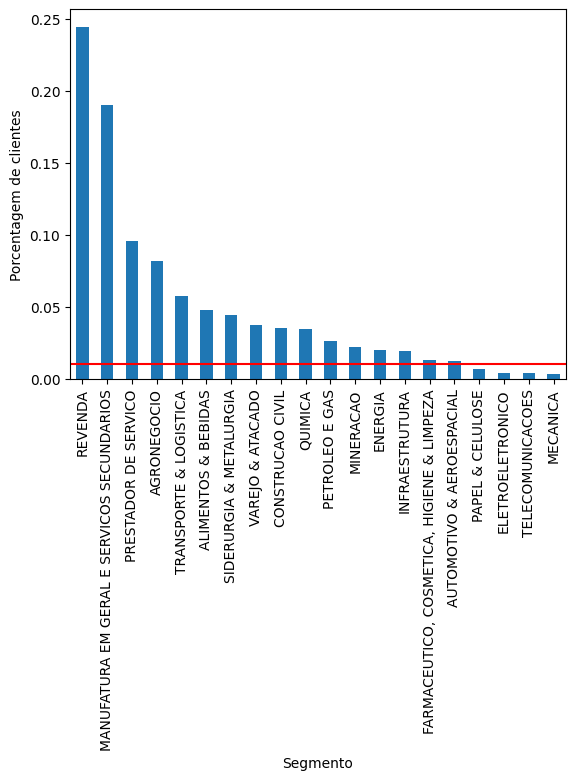

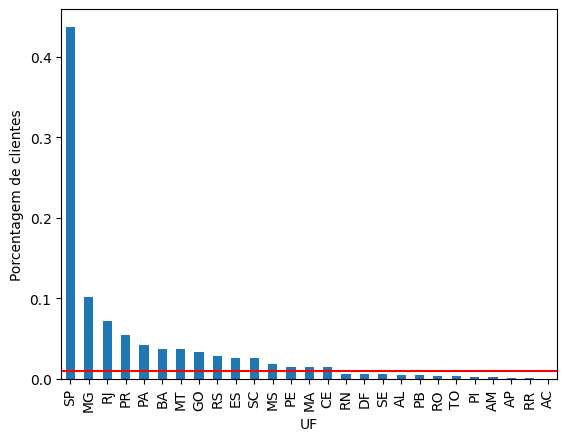

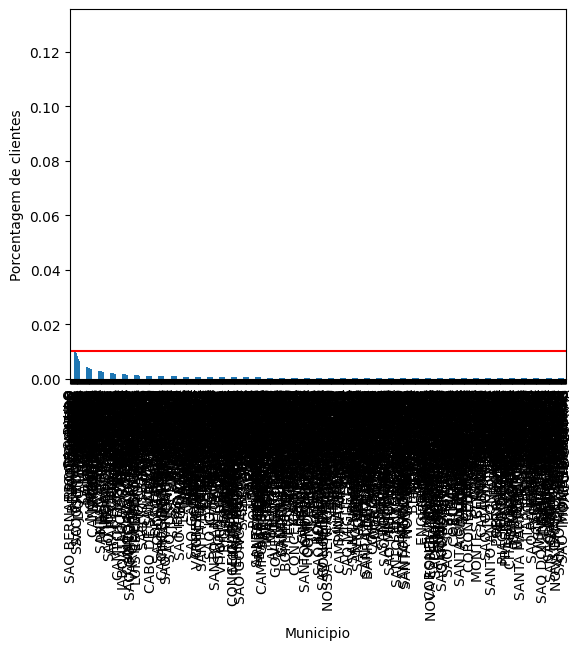

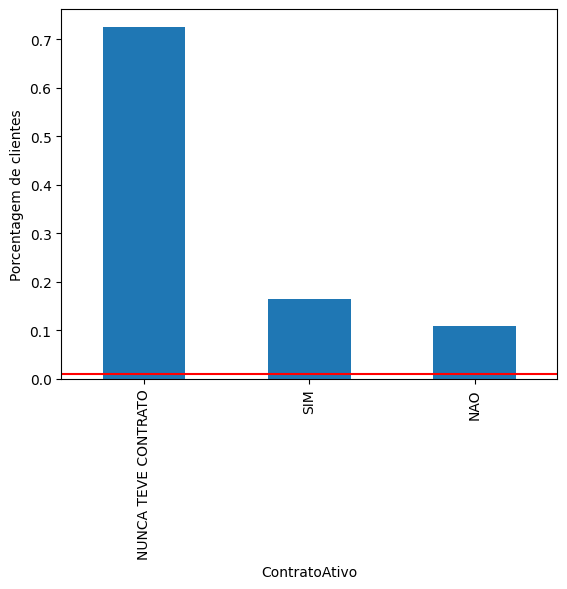

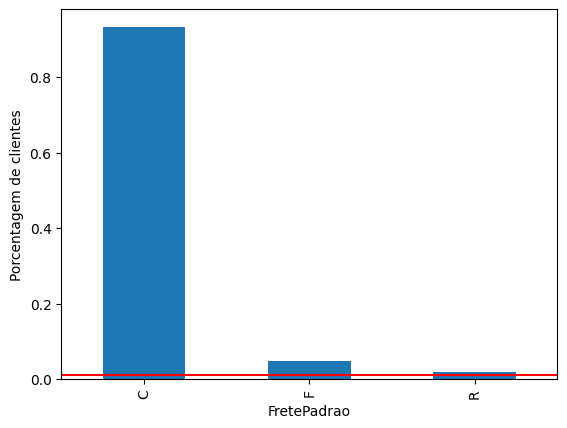

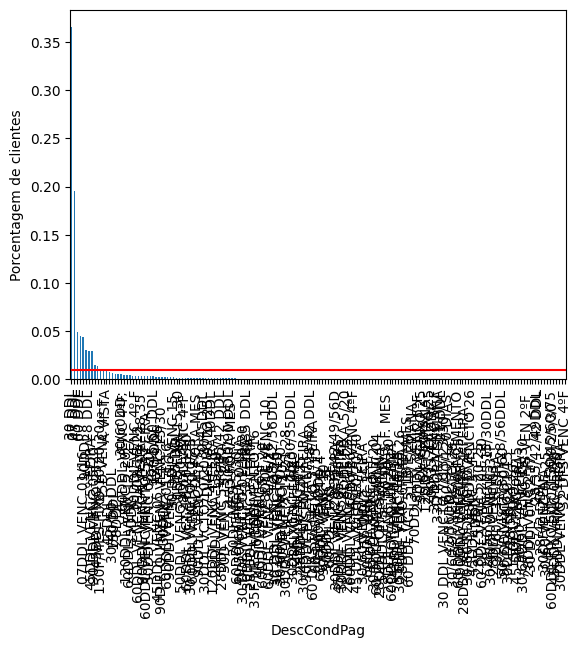

In [13]:
total_clientes = len(df_base)

for col in lista_colunas_qualitativas:
    # conta o número de clientes por categoria e divide pelo número total de clientes
    # ou seja, porcentagem de clientes por categoria
    temp_df = pd.Series(df_base[col].value_counts() / total_clientes)

    # faz um gráfico com as porcetanges obtidas
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # adiciona linha em 1%
    fig.axhline(y=0.01, color='red')
    fig.set_ylabel('Porcentagem de clientes')
    plt.show()

In [14]:
qual_muitas_categ = ['Municipio', 'DescCondPag']

In [15]:
def agrupa_categorias_raras(df, var, cutoff):
    total_clientes = len(df)
    # calcula a porcentagem de clientes em cada categoria
    temp_df = pd.Series(df[var].value_counts() / total_clientes)

    # cria um dicionário para substituir categorias raras com string 'Outras'
    grouping_dict = {
        k: ('Outros' if k not in temp_df[temp_df >= cutoff].index else k)
        for k in temp_df.index
    }

    # substitui categorias raras
    tmp = df[var].map(grouping_dict)

    return tmp

In [16]:
for col in lista_colunas_qualitativas:
    if col not in qual_muitas_categ:
        df_base[f'{col}_agrupado'] = agrupa_categorias_raras(df_base, f'{col}', 0.01)
    elif col in qual_muitas_categ:
        df_base[f'{col}_agrupado'] = agrupa_categorias_raras(df_base, f'{col}', 0.005)

In [17]:
for coluna in lista_colunas_qualitativas:
    print(df_base[f'{coluna}_agrupado'].value_counts())
    print('-=' * 20)
    print(df_base[f'{coluna}_agrupado'].value_counts(normalize=True).mul(100))
    print('-=' * 20)

Segmento_agrupado
REVENDA                                       1471
MANUFATURA EM GERAL E SERVICOS SECUNDARIOS    1146
PRESTADOR DE SERVICO                           576
AGRONEGOCIO                                    491
TRANSPORTE & LOGISTICA                         348
ALIMENTOS & BEBIDAS                            288
SIDERURGIA & METALURGIA                        265
VAREJO & ATACADO                               223
CONSTRUCAO CIVIL                               211
QUIMICA                                        207
PETROLEO E GAS                                 159
MINERACAO                                      133
ENERGIA                                        122
INFRAESTRUTURA                                 118
Outros                                         108
FARMACEUTICO, COSMETICA, HIGIENE & LIMPEZA      80
AUTOMOTIVO & AEROESPACIAL                       75
Name: count, dtype: int64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Segmento_agrupado
REVENDA                       

In [18]:
for col in lista_colunas_qualitativas:
    print(df_base.groupby(['Churn', f'{col}_agrupado'])['Churn'].count())
    print('-=' * 20)
    print(df_base.groupby(['Churn', f'{col}_agrupado'])['Churn'].count().div(total_clientes).mul(100))
    print('-=' * 20)

Churn  Segmento_agrupado                         
0      AGRONEGOCIO                                   204
       ALIMENTOS & BEBIDAS                            61
       AUTOMOTIVO & AEROESPACIAL                      25
       CONSTRUCAO CIVIL                               38
       ENERGIA                                        60
       FARMACEUTICO, COSMETICA, HIGIENE & LIMPEZA     28
       INFRAESTRUTURA                                  5
       MANUFATURA EM GERAL E SERVICOS SECUNDARIOS    175
       MINERACAO                                      79
       Outros                                         36
       PETROLEO E GAS                                 91
       PRESTADOR DE SERVICO                          127
       QUIMICA                                        36
       REVENDA                                       623
       SIDERURGIA & METALURGIA                       116
       TRANSPORTE & LOGISTICA                        218
       VAREJO & ATACADO               

In [19]:
print(df_base.groupby(['Churn'])['Churn'].count())
print(df_base.groupby(['Churn'])['Churn'].count().div(total_clientes).mul(100))
print(len(df_base['Churn']))

Churn
0    1966
1    4055
Name: Churn, dtype: int64
Churn
0   32.65
1   67.35
Name: Churn, dtype: float64
6021


In [20]:
for col in lista_colunas_qualitativas:
    print('Não')
    print(df_base[df_base['Churn'] == 0][f'{col}_agrupado'].value_counts(normalize=True).mul(100))
    print('-=' * 20)
    print('Sim')
    print(df_base[df_base['Churn'] == 1][f'{col}_agrupado'].value_counts(normalize=True).mul(100))
    print('-=' * 20)
    print(df_base.groupby(['Churn', f'{col}_agrupado'])['Churn'].count())
    print('-=' * 20)

Não
Segmento_agrupado
REVENDA                                      31.69
TRANSPORTE & LOGISTICA                       11.09
AGRONEGOCIO                                  10.38
MANUFATURA EM GERAL E SERVICOS SECUNDARIOS    8.90
PRESTADOR DE SERVICO                          6.46
SIDERURGIA & METALURGIA                       5.90
PETROLEO E GAS                                4.63
MINERACAO                                     4.02
ALIMENTOS & BEBIDAS                           3.10
ENERGIA                                       3.05
VAREJO & ATACADO                              2.24
CONSTRUCAO CIVIL                              1.93
Outros                                        1.83
QUIMICA                                       1.83
FARMACEUTICO, COSMETICA, HIGIENE & LIMPEZA    1.42
AUTOMOTIVO & AEROESPACIAL                     1.27
INFRAESTRUTURA                                0.25
Name: proportion, dtype: float64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Sim
Segmento_agrupado
MANUFATURA EM G

In [21]:
nova_lista_colunas_qualitativas = ['Segmento_agrupado', 'UF_agrupado', 'Municipio_agrupado', 'ContratoAtivo_agrupado', 
                                   'FretePadrao_agrupado', 'DescCondPag_agrupado']
df_base_tratada = df_base.drop(lista_colunas_qualitativas, axis=1)
df_base_tratada

,MediaMargemRelativa,SomaValorFaturado,ProdutosDiferentesComprados,TicketMedio,QuantidadePedidos,QuantidadeMesesComprando,TaxaConversaoOrcamentos,MesesConsecutivosComprando,MediaFrete,Churn,ClienteLoja,Segmento_agrupado,UF_agrupado,Municipio_agrupado,ContratoAtivo_agrupado,FretePadrao_agrupado,DescCondPag_agrupado
0,0.24,635955.15,43,2255.16,178,31,0.81,34,92.04,0,0,Outros,PR,Outros,NAO,C,45DDL VENC 5º FEIRA
1,0.19,8116541.94,107,2021.55,3306,35,0.91,39,65.53,0,1,Outros,SP,SAO PAULO,NAO,C,45DDL VENC 5º FEIRA
2,0.21,80423.38,28,505.81,31,17,0.61,20,35.66,0,2,Outros,BA,SALVADOR,NAO,C,45DDL VENC 5º FEIRA
3,0.28,89919.71,40,1045.58,28,14,0.70,15,57.86,1,3,Outros,RS,Outros,NAO,C,45DDL VENC 5º FEIRA
4,0.23,89882.20,42,502.14,31,15,0.75,18,33.70,0,4,Outros,PE,Outros,NAO,C,45DDL VENC 5º FEIRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6033,0.25,5658.20,3,1886.07,2,1,0.50,1,133.76,0,6034,REVENDA,MA,Outros,NUNCA TEVE CONTRATO,C,30 DDL
6034,0.16,1477.76,5,295.55,1,1,0.25,1,12.95,0,6035,REVENDA,PR,CURITIBA,NUNCA TEVE CONTRATO,C,07 DDL
6035,0.15,4405.01,3,1468.34,1,1,0.50,1,0.00,0,6036,REVENDA,RJ,RIO DE JANEIRO,NUNCA TEVE CONTRATO,C,07 DDL
6036,0.20,3007.02,10,300.70,1,1,1.00,2,0.00,0,6037,REVENDA,SP,GUARULHOS,NUNCA TEVE CONTRATO,C,07 DDL


In [22]:
df_base_dummies = pd.get_dummies(df_base_tratada,
                                 columns=nova_lista_colunas_qualitativas,
                                 dtype=int,
                                 drop_first=True)
df_base_dummies

,MediaMargemRelativa,SomaValorFaturado,ProdutosDiferentesComprados,TicketMedio,QuantidadePedidos,QuantidadeMesesComprando,TaxaConversaoOrcamentos,MesesConsecutivosComprando,MediaFrete,Churn,...,DescCondPag_agrupado_45 DDL,DescCondPag_agrupado_45D VENC 4ª F,DescCondPag_agrupado_45DDL,DescCondPag_agrupado_45DDL FIXO 25,DescCondPag_agrupado_45DDL VENC 5º FEIRA,DescCondPag_agrupado_60 DDL,DescCondPag_agrupado_90 DDL VENC 05/20,DescCondPag_agrupado_90DDL,DescCondPag_agrupado_A VISTA,DescCondPag_agrupado_Outros
0,0.24,635955.15,43,2255.16,178,31,0.81,34,92.04,0,...,0,0,0,0,1,0,0,0,0,0
1,0.19,8116541.94,107,2021.55,3306,35,0.91,39,65.53,0,...,0,0,0,0,1,0,0,0,0,0
2,0.21,80423.38,28,505.81,31,17,0.61,20,35.66,0,...,0,0,0,0,1,0,0,0,0,0
3,0.28,89919.71,40,1045.58,28,14,0.70,15,57.86,1,...,0,0,0,0,1,0,0,0,0,0
4,0.23,89882.20,42,502.14,31,15,0.75,18,33.70,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6033,0.25,5658.20,3,1886.07,2,1,0.50,1,133.76,0,...,0,0,0,0,0,0,0,0,0,0
6034,0.16,1477.76,5,295.55,1,1,0.25,1,12.95,0,...,0,0,0,0,0,0,0,0,0,0
6035,0.15,4405.01,3,1468.34,1,1,0.50,1,0.00,0,...,0,0,0,0,0,0,0,0,0,0
6036,0.20,3007.02,10,300.70,1,1,1.00,2,0.00,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
X = df_base_dummies.drop(columns=['Churn'])
y = df_base_dummies['Churn']

# Vamos escolher 70% das observações para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=100)

In [24]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 4214 entries, 3919 to 5657
Series name: Churn
Non-Null Count  Dtype
--------------  -----
4214 non-null   int64
dtypes: int64(1)
memory usage: 65.8 KB


In [25]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4214 entries, 3919 to 5657
Data columns (total 91 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   MediaMargemRelativa                                           4214 non-null   float64
 1   SomaValorFaturado                                             4214 non-null   float64
 2   ProdutosDiferentesComprados                                   4214 non-null   int64  
 3   TicketMedio                                                   4214 non-null   float64
 4   QuantidadePedidos                                             4214 non-null   int64  
 5   QuantidadeMesesComprando                                      4214 non-null   int64  
 6   TaxaConversaoOrcamentos                                       4214 non-null   float64
 7   MesesConsecutivosComprando                                    4214 non-

In [26]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 1807 entries, 4131 to 1952
Series name: Churn
Non-Null Count  Dtype
--------------  -----
1807 non-null   int64
dtypes: int64(1)
memory usage: 28.2 KB


In [27]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1807 entries, 4131 to 1952
Data columns (total 91 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   MediaMargemRelativa                                           1807 non-null   float64
 1   SomaValorFaturado                                             1807 non-null   float64
 2   ProdutosDiferentesComprados                                   1807 non-null   int64  
 3   TicketMedio                                                   1807 non-null   float64
 4   QuantidadePedidos                                             1807 non-null   int64  
 5   QuantidadeMesesComprando                                      1807 non-null   int64  
 6   TaxaConversaoOrcamentos                                       1807 non-null   float64
 7   MesesConsecutivosComprando                                    1807 non-

In [28]:
reg_log = LogisticRegression(random_state=100)
np.random.seed(100)

# Defining hyperparameters to search over
params = {
    'penalty':['l1','l2','elasticnet','none'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [100, 1000, 2500, 5000, 10000]
}

# Defining randomized search
reg_log_cv = RandomizedSearchCV(estimator=reg_log, 
                            param_distributions=params,
                            random_state=100,
                            n_jobs=-1,
                            cv=5)

# Fitting randomized search to training data
reg_log_cv.fit(X_train, y_train)
print(reg_log_cv.best_params_)

# Model predictions 
y_pred_reg_log = reg_log_cv.predict(X_test)
prob_pos = reg_log_cv.predict_proba(X_test)[:,1]

# Model performance
reg_log_accuracy = accuracy_score(y_test, y_pred_reg_log)
print(("Acurácia: {:.4f}".format(reg_log_accuracy)))

reg_log_precision = precision_score(y_test, y_pred_reg_log)
print("Precisão: {:.4f}".format(reg_log_precision))

reg_log_recall = recall_score(y_test, y_pred_reg_log)
print("Sensitividade: {:.4f}".format(reg_log_recall))

reg_log_fpr = recall_score(y_test, y_pred_reg_log, pos_label=0)
print("Especificidade: {:.4f}".format(reg_log_fpr))

reg_log_f1 = f1_score(y_test, y_pred_reg_log)
print("Pontuação F1: {:.4f}".format(reg_log_f1))

reg_log_auc_value = roc_auc_score(y_test, prob_pos)
print("AUC: {:.4f}".format(reg_log_auc_value))

{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'fit_intercept': True, 'C': 10}
Acurácia: 0.8367
Precisão: 0.8543
Sensitividade: 0.9139
Especificidade: 0.6769
Pontuação F1: 0.8831
AUC: 0.9141


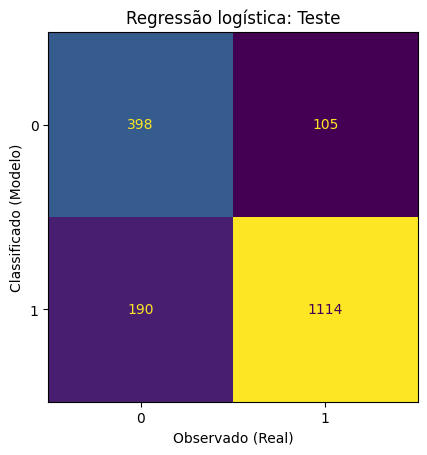

In [29]:
cm = confusion_matrix(y_pred_reg_log, y_test)
cm_reg_log = ConfusionMatrixDisplay(cm)

plt.rcParams['figure.dpi'] = 100
cm_reg_log.plot(colorbar=False, cmap='viridis')
plt.title('Regressão logística: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

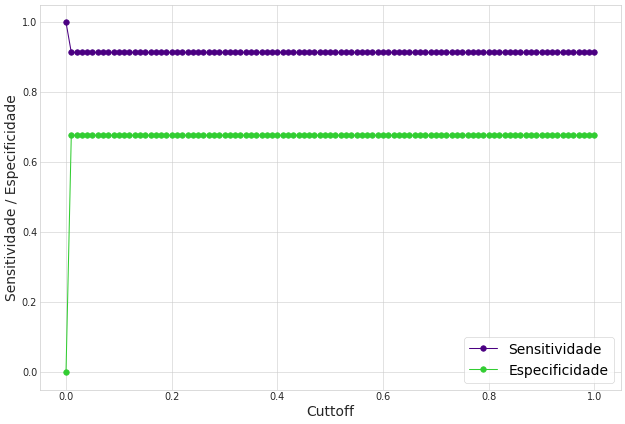

In [30]:
# Até o momento, foram extraídos 3 vetores: 'sensitividade',
#'especificidade' e 'cutoffs'. Assim, criamos um dataframe que contém
#os vetores mencionados

dados_plotagem = espec_sens(observado = y_test,
                            predicts = y_pred_reg_log)
dados_plotagem

# Plotagem de um gráfico que mostra a variação da especificidade e da
#sensitividade em função do cutoff

plt.figure(figsize=(15,10), dpi=50)
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.sensitividade, marker='o',
         color='indigo', markersize=8)
    plt.plot(dados_plotagem.cutoffs,dados_plotagem.especificidade, marker='o',
         color='limegreen', markersize=8)
plt.xlabel('Cuttoff', fontsize=20)
plt.ylabel('Sensitividade / Especificidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(['Sensitividade', 'Especificidade'], fontsize=20)
plt.show()

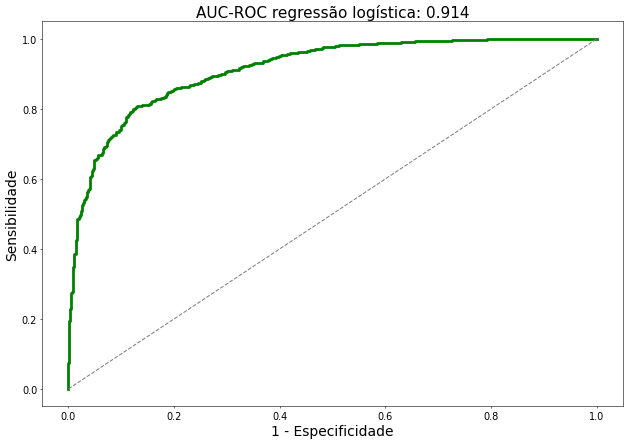

In [31]:
# Parametrizando a função da curva ROC (real vs. previsto)
fpr_reg_log, tpr_reg_log, thresholds_reg_log = roc_curve(y_test, prob_pos)
roc_auc_xgb = auc(fpr_reg_log, tpr_reg_log)

# Plotando a curva ROC
plt.figure(figsize=(15,10), dpi=50)
plt.plot(fpr_reg_log, tpr_reg_log, color='green', linewidth=4)
plt.plot(fpr_reg_log, fpr_reg_log, color='gray', linestyle='dashed')
plt.title('AUC-ROC regressão logística: %g' % round(roc_auc_xgb, 3), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensibilidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

In [32]:
dt = DecisionTreeClassifier(random_state=100)
np.random.seed(100)

params = {
    'criterion': ['gini', 'entropy', 'logloss'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, None],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

cv_dt = RandomizedSearchCV(
    dt, 
    param_distributions=params, 
    random_state=100,
    n_jobs=-1,
    cv=5
)

cv_dt.fit(X_train, y_train)
print(cv_dt.best_params_)

best_dt = cv_dt.best_estimator_
best_dt.fit(X_train, y_train)

y_pred_dt = best_dt.predict(X_test)
prob_pos = best_dt.predict_proba(X_test)[:,1]

dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(("Acurácia: {:.4f}".format(dt_accuracy)))

dt_precision = precision_score(y_test, y_pred_dt)
print("Precisão: {:.4f}".format(dt_precision))

dt_recall = recall_score(y_test, y_pred_dt)
print("Sensitividade: {:.4f}".format(dt_recall))

dt_fpr = recall_score(y_test, y_pred_dt, pos_label=0)
print("Especificidade: {:.4f}".format(dt_fpr))

dt_f1 = f1_score(y_test, y_pred_dt)
print("Pontuação F1: {:.4f}".format(dt_f1))

dt_auc_value = roc_auc_score(y_test, prob_pos)
print("AUC: {:.4f}".format(dt_auc_value))

{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'criterion': 'gini'}
Acurácia: 0.7919
Precisão: 0.8593
Sensitividade: 0.8269
Especificidade: 0.7194
Pontuação F1: 0.8428
AUC: 0.7937


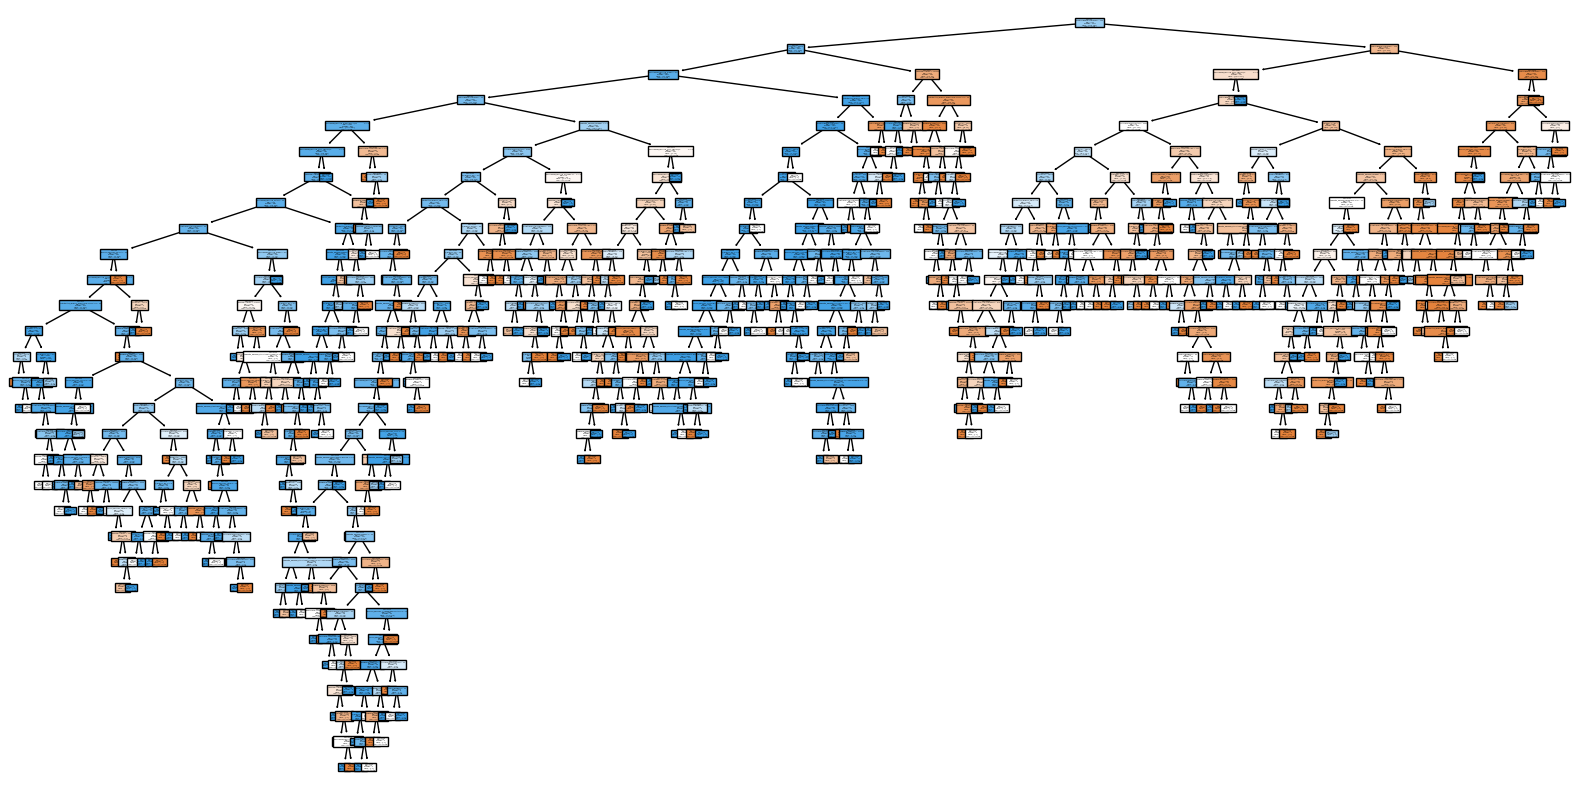

In [33]:
plt.figure(figsize=(20,10), dpi=100)
plot_tree(best_dt,
          feature_names=X.columns.tolist(),
          class_names=['Não churner','Churner'],
          proportion=False,
          filled=True,
          node_ids=True)
plt.show()

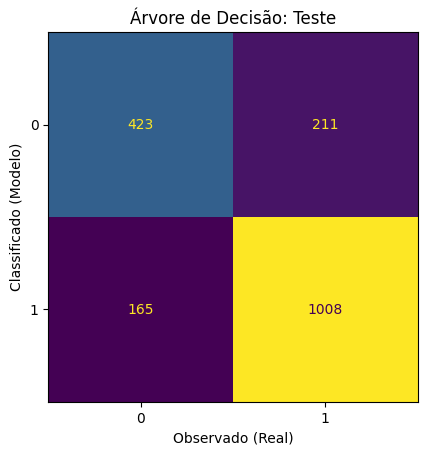

In [34]:
#%% Matriz de confusão (base de teste)
cm = confusion_matrix(y_pred_dt, y_test)
cm_dt = ConfusionMatrixDisplay(cm)

plt.rcParams['figure.dpi'] = 100
cm_dt.plot(colorbar=False, cmap='viridis')
plt.title('Árvore de Decisão: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

In [35]:
rf = RandomForestClassifier(random_state=100)
np.random.seed(100)

params = {
    'n_estimators': [10, 20, 50, 100, 200, 400],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, None],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False],
    'oob_score': [True, False],
}

cv_rf = RandomizedSearchCV(
    rf,
    param_distributions=params,
    random_state=100,
    n_jobs=-1,
    cv=5
)

cv_rf.fit(X_train, y_train)
print(cv_rf.best_params_)

# Model predictions
y_pred_rf = cv_rf.predict(X_test)
prob_pos = cv_rf.predict_proba(X_test)[:,1]

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(("Acurácia: {:.4f}".format(rf_accuracy)))

rf_precision = precision_score(y_test, y_pred_rf)
print("Precisão: {:.4f}".format(rf_precision))

rf_recall = recall_score(y_test, y_pred_rf)
print("Sensitividade: {:.4f}".format(rf_recall))

rf_fpr = recall_score(y_test, y_pred_rf, pos_label=0)
print("Especificidade: {:.4f}".format(rf_fpr))

rf_f1 = f1_score(y_test, y_pred_rf)
print("Pontuação F1: {:.4f}".format(rf_f1))

rf_auc_value = roc_auc_score(y_test, prob_pos)
print("AUC: {:.4f}".format(rf_auc_value))

{'oob_score': True, 'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'gini', 'bootstrap': True}
Acurácia: 0.8467
Precisão: 0.8584
Sensitividade: 0.9253
Especificidade: 0.6837
Pontuação F1: 0.8906
AUC: 0.9187


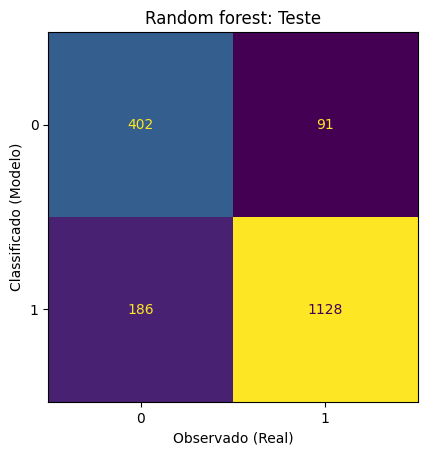

In [36]:
cm = confusion_matrix(y_pred_rf, y_test)
cm_rf = ConfusionMatrixDisplay(cm)

plt.rcParams['figure.dpi'] = 100
cm_rf.plot(colorbar=False, cmap='viridis')
plt.title('Random forest: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

In [37]:
xgb = XGBClassifier(random_state=100)
np.random.seed(100)

params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7, 9],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'objective': ['reg:squarederror', 'reg:squaredlogerror', 'reg:logistic', 
                  'binary:logistic', 'binary:logitraw', 'binary:hinge',
                  'multi:softmax', 'multi:softprob'],
    'eval_metric': ['rmse', 'mae', 'logloss', 'error', 'merro',
                    'mlogloss', 'auc', 'aucpr'],
}

cv_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=params,
    random_state=100,
    n_jobs=-1,
    cv=5
)

cv_xgb.fit(X_train, y_train)
print(cv_xgb.best_params_)

# Mode predictions 
y_pred_xgb = cv_xgb.predict(X_test)
prob_pos = cv_xgb.predict_proba(X_test)[:,1]

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(("Acurácia: {:.4f}".format(xgb_accuracy)))

xgb_precision = precision_score(y_test, y_pred_xgb)
print("Precisão: {:.4f}".format(xgb_precision))

xgb_recall = recall_score(y_test, y_pred_xgb)
print("Sensitividade: {:.4f}".format(xgb_recall))

xgb_fpr = recall_score(y_test, y_pred_xgb, pos_label=0)
print("Especificidade: {:.4f}".format(xgb_fpr))

xgb_f1 = f1_score(y_test, y_pred_xgb)
print("Pontuação F1: {:.4f}".format(xgb_f1))

xgb_auc_value = roc_auc_score(y_test, prob_pos)
print("AUC: {:.4f}".format(xgb_auc_value))

{'subsample': 0.5, 'objective': 'reg:squarederror', 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 1.0, 'eval_metric': 'auc', 'colsample_bytree': 0.5}
Acurácia: 0.8594
Precisão: 0.8680
Sensitividade: 0.9336
Especificidade: 0.7058
Pontuação F1: 0.8996
AUC: 0.9287


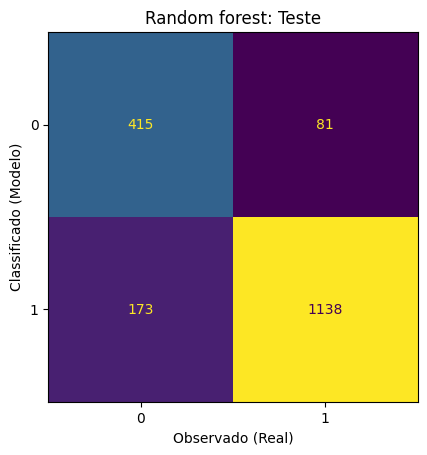

In [38]:
cm = confusion_matrix(y_pred_xgb, y_test)
cm_xgb = ConfusionMatrixDisplay(cm)

plt.rcParams['figure.dpi'] = 100
cm_xgb.plot(colorbar=False, cmap='viridis')
plt.title('Random forest: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

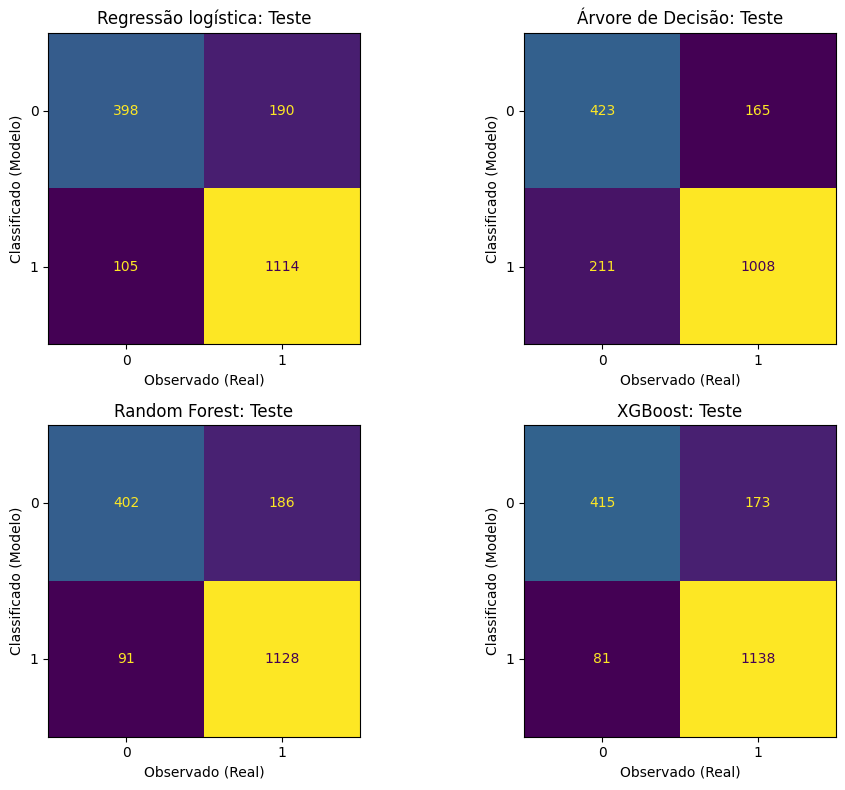

In [39]:
# Gere suas predições separadas para cada modelo
# Exemplo (substitua pelos seus próprios):
# y_pred_log, y_pred_dt, y_pred_rf, y_pred_xgb = ...

fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Cria grid 2x2
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Espaçamento entre os subplots

# 1. Regressão Logística
cm = confusion_matrix(y_test, y_pred_reg_log)
ConfusionMatrixDisplay(cm).plot(ax=axes[0, 0], colorbar=False, cmap='viridis')
axes[0, 0].set_title('Regressão logística: Teste')
axes[0, 0].set_xlabel('Observado (Real)')
axes[0, 0].set_ylabel('Classificado (Modelo)')

# 2. Árvore de Decisão
cm = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm).plot(ax=axes[0, 1], colorbar=False, cmap='viridis')
axes[0, 1].set_title('Árvore de Decisão: Teste')
axes[0, 1].set_xlabel('Observado (Real)')
axes[0, 1].set_ylabel('Classificado (Modelo)')

# 3. Random Forest
cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm).plot(ax=axes[1, 0], colorbar=False, cmap='viridis')
axes[1, 0].set_title('Random Forest: Teste')
axes[1, 0].set_xlabel('Observado (Real)')
axes[1, 0].set_ylabel('Classificado (Modelo)')

# 4. XGBoost
cm = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(cm).plot(ax=axes[1, 1], colorbar=False, cmap='viridis')
axes[1, 1].set_title('XGBoost: Teste')
axes[1, 1].set_xlabel('Observado (Real)')
axes[1, 1].set_ylabel('Classificado (Modelo)')

plt.tight_layout()
plt.show()

In [40]:
import numpy as np
import pandas as pd
import shap

# 1) Explainer e SHAP no X_test
explainer   = shap.TreeExplainer(cv_rf.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Diagnóstico
print("shap_values type:", type(shap_values))
if isinstance(shap_values, list):
    print("  list len:", len(shap_values))
    print("  shap_values[0].shape:", shap_values[0].shape)
    print("  shap_values[1].shape:", shap_values[1].shape)
else:
    print("  array shape:", shap_values.shape)

# 2) Extrai só a classe positiva (índice 1) — ajuste se quiser outra classe
sv_pos = shap_values[:, :, 1]
print("sv_pos.shape:", sv_pos.shape)

# 3) Calcula a média dos valores absolutos de SHAP para cada feature
importances = np.mean(np.abs(sv_pos), axis=0)

# 4) Monta um DataFrame e ordena
df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': importances
})
df_sorted = df.sort_values('importance', ascending=False).reset_index(drop=True)

# 5) Exibe ou salva a tabela completa
print(df_sorted.to_string())

shap_values type: <class 'numpy.ndarray'>
  array shape: (1807, 91, 2)
sv_pos.shape: (1807, 91)
                                                         feature  importance
0                                    DescCondPag_agrupado_30 DDL        0.05
1                                     MesesConsecutivosComprando        0.05
2                                       QuantidadeMesesComprando        0.05
3                                              QuantidadePedidos        0.04
4                                              SomaValorFaturado        0.03
5                                                    ClienteLoja        0.03
6                                    ProdutosDiferentesComprados        0.03
7                                      Segmento_agrupado_REVENDA        0.02
8                                     ContratoAtivo_agrupado_SIM        0.02
9                                        TaxaConversaoOrcamentos        0.02
10                                                    Med

In [41]:
print("X_test shape:", X_test.shape)
print("len(importances):", importances.shape[0])
print("n_features (cols):", len(X_test.columns))

X_test shape: (1807, 91)
len(importances): 91
n_features (cols): 91
